### Build up model `analysis tables`

---

This workbook demonstrates EDA to read in parameters saved furing multiple model runs, in this case the modexp-a-<N> / modexp-b-<N> series and output the analysis tables. These anlysis tables can then be used to do analysis of residuals, model comparison, and vote aggregation.

Inputs: `models/<mod_name>.pkl` and `models/model-config/<mod_name>.json`

Output: `models/model-analysis/`:
    - `df_agg.csv`
    - `df_pred.csv`

    

In [16]:
from fastai2.vision.all import load_learner, get_image_files
import torch
from pathlib import Path
import json, os, sys
import pandas as pd
sys.path.append('..')
from modules.trainutils import piece_class_parse
from modules.trainutils import my_metrics

In [17]:
test_path = Path('../../../other-chess-data/regulation-test-1')
modelconfig_path = Path('../models/model-config')

### `df_agg`  summarizes:
 - model hyper params
 - perf on test set

In [21]:
config_dir = Path('../models/model-config/')

df = pd.DataFrame([])

for fn in os.listdir(config_dir):
    
    with open(config_dir / fn, 'r') as f:
        d = json.load(f)
    
    df = pd.concat((df, pd.DataFrame(d, index=[fn])))

df_agg = df.copy()

In [22]:
df.sort_values(by = 'test_loss', ascending=True).T

,expmod-b-8.json,expmod-b-1.json,expmod-b-6.json,expmod-b-0.json,expmod-a-0.json,expmod-a-1.json,expmod-b-2.json,expmod-b-5.json,expmod-b-7.json,expmod-a-6.json,expmod-b-4.json,expmod-a-5.json,expmod-a-8.json,expmod-a-7.json,expmod-a-2.json,expmod-b-3.json,expmod-a-4.json,expmod-a-3.json
_model_arch,resnet50,resnet50,resnet50,resnet50,resnet50,resnet50,resnet50,resnet50,resnet50,resnet50,resnet50,resnet50,resnet50,resnet50,resnet50,resnet50,resnet50,resnet50
_fit_one_cycle_epochs,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
_fine_tune_epochs,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
_train_seed,17,42,17,42,42,42,17,42,42,17,17,42,17,42,17,42,17,42
_mult,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
_max_lighting,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
_max_warp,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4
_max_rotate,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
_resize_method,pad,pad,squish,pad,pad,pad,pad,squish,pad,squish,crop,squish,pad,pad,pad,crop,crop,crop
_pad_mode,reflection,zeros,zeros,zeros,zeros,zeros,zeros,zeros,reflection,zeros,zeros,zeros,reflection,reflection,zeros,zeros,zeros,zeros


In [28]:
df_agg.to_csv('../models/model-analysis/expmod-df_agg.csv', 
             index=False)

As we can see: pad > squish > crop

### `df_pred` - compare individual model predictions

for each item in test_set
 - fn / label
 - actual class enum
 - predicted class enum
 - loss (BCE)

In [23]:
model_dir = '../models/'
filter_crit = 'expmod'

d_preds = {}
model_fns = [e for e in os.listdir(model_dir) 
             if filter_crit in e]

for model_fn in model_fns:
    
    learn = load_learner(model_dir + model_fn)
    
    test_dl = learn.dls.test_dl(get_image_files(test_path), 
                                with_labels=True)
    
    preds = learn.get_preds(dl= test_dl, with_loss=True)
    
    fns =     [e.name for e in test_dl.items]
    labels =  [piece_class_parse(e) for e in fns]
    
    y_actual = preds[1].tolist()
    y_hat =    torch.argmax(preds[0], dim=1).tolist()
    y_loss =   preds[2].tolist()
    
    mod_name = model_fn.split('.')[0]
    
    d_preds[mod_name]  = {
        'fn':     fns.copy(),
        'label':  labels.copy(),
        'actual': y_actual.copy(),
        'pred':   y_hat.copy(), 
        'loss':   y_loss.copy(),
        }


In [24]:
for i, (mod_name, mod_d) in enumerate(d_preds.items()):
    
    if i == 0:
        
        d_base = {
            'fn':     mod_d['fn'],
            'label':  mod_d['label'],
            'actual': mod_d['actual'],
        }
        
        df = pd.DataFrame(d_base) 
    
    d_learner = {
        ('pred_' + mod_name):   mod_d['pred'], 
        ('loss_' + mod_name):   mod_d['loss'],
    }
    
    df = pd.concat((df, pd.DataFrame(d_learner)), axis=1)
        
df_pred = df.copy()    

In [26]:
df_pred.head(3)

,fn,label,actual,pred_expmod-b-2,loss_expmod-b-2,pred_expmod-a-0,loss_expmod-a-0,pred_expmod-a-2,loss_expmod-a-2,pred_expmod-b-3,...,pred_expmod-b-7,loss_expmod-b-7,pred_expmod-a-1,loss_expmod-a-1,pred_expmod-b-5,loss_expmod-b-5,pred_expmod-b-1,loss_expmod-b-1,pred_expmod-a-4,loss_expmod-a-4
0,00045_white-knight.jpg,white-knight,8,8,0.291397,8,0.012227,8,0.056793,9,...,2,2.252499,8,0.032057,2,3.967623,8,0.096933,2,1.630746
1,00036_black-queen.jpg,black-queen,4,4,0.682489,4,0.373041,4,0.206899,9,...,4,0.138620,4,0.109868,5,2.272756,3,1.720904,3,4.611205
2,00013_black-rook.jpg,black-rook,5,5,0.041660,5,0.005947,5,0.231042,5,...,5,0.017676,5,0.001657,5,0.000771,5,0.006509,5,0.003965


In [27]:
df.to_csv('../models/model-analysis/expmod-df_pred.csv',
          index=False)

### `df_correct` - a helper tables
 - for each model, does pred_modname match actual?
   - 1 if yes, 0 otherwise
   
No need to save the table, we can build it from df_pred

In [29]:
mod_names = list(d_preds.keys())

df_correct = pd.DataFrame([])

for mod_name in mod_names:
    
    df_correct[mod_name] = (
      (df_pred['actual'] == 
       df_pred['pred_' + mod_name]).astype('int')
    )

In [30]:
df_correct.head(3)

,expmod-b-2,expmod-a-0,expmod-a-2,expmod-b-3,expmod-a-6,expmod-b-8,expmod-a-3,expmod-a-7,expmod-b-6,expmod-a-5,expmod-a-8,expmod-b-0,expmod-b-4,expmod-b-7,expmod-a-1,expmod-b-5,expmod-b-1,expmod-a-4
0,1,1,1,0,1,1,0,1,1,1,1,1,0,0,1,0,1,0
1,1,1,1,0,1,1,0,1,1,1,1,1,0,1,1,0,0,0
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


##### Analytics, differences in models
where is the best model wrong but other models are correct?

In [60]:
cmp_model = 'expmod-b-2'

other_models = [col for col in df_correct.columns
                if col != cmp_model]

mask_cmp_correct =   (df_correct[cmp_model] == 1)
mask_cmp_incorrect = (df_correct[cmp_model] == 0)    

In [69]:
print(f"cmp model: {cmp_model} | " + 
      f"correct {mask_cmp_correct.sum()} " + 
      f"incorrect {mask_cmp_incorrect.sum()}")

cmp model: expmod-b-2 | correct 48 incorrect 12


In [70]:
theyre_correct = df_correct.loc[mask_cmp_incorrect, other_models]

theyre_correct.sum().sort_values(ascending=False)

expmod-b-6    6
expmod-b-5    5
expmod-b-7    5
expmod-b-1    4
expmod-b-4    4
expmod-b-0    4
expmod-a-5    4
expmod-a-4    3
expmod-a-1    3
expmod-a-8    3
expmod-a-3    3
expmod-a-6    3
expmod-b-3    3
expmod-a-0    2
expmod-a-7    1
expmod-a-2    1
dtype: int64

##### Analytics, vote_agg

In [73]:
preds_df = df_pred.loc[:,[c for c in df_pred.columns if 'pred_' in c]]

In [98]:
vote_agg_1 = preds_df.T.apply(pd.value_counts).apply(np.argmax)

In [101]:
(vote_agg_1 == df_pred['actual']).sum()

48

OK so same number correct as best model

In [ ]:
cmp_model = 'expmod-b-2'

In [ ]:
_col = [col for col in preds_df if cmp_model in col]

In [104]:
_col

['pred_expmod-b-2']

In [106]:
disagrees = (vote_agg_1 != preds_df.loc[:, 'pred_' + cmp_model])
disagrees.sum()

6

OK so 6 disagrees where 3 must be right in 3 wrong

In [108]:
preds_df = df_pred.loc[:,[c for c in df_pred.columns if 'pred_' in c]]

In [111]:
these_cols = [col for col in preds_df.columns
             if '-b-' in col]
these_cols

['pred_expmod-b-2',
 'pred_expmod-b-3',
 'pred_expmod-b-6',
 'pred_expmod-b-0',
 'pred_expmod-b-4',
 'pred_expmod-b-7',
 'pred_expmod-b-5',
 'pred_expmod-b-1']

In [113]:
preds_df = df_pred.loc[:,these_cols]

vote_agg_1 = preds_df.T.apply(pd.value_counts).apply(np.argmax)

(vote_agg_1 == df_pred['actual']).sum()

51

Yay! vote aggregation worked

##### Try again with top 4 models

In [122]:
(df_agg.sort_values(by = 'test_loss', ascending=True)
     .T.iloc[:, :4].loc['test_loss',:])

expmod-b-1.json     0.67507
expmod-b-6.json    0.791359
expmod-b-0.json    0.807995
expmod-a-0.json    0.835703
Name: test_loss, dtype: object

In [123]:
preds_df = df_pred.loc[:,[c for c in df_pred.columns if 'pred_' in c]]

these_cols = [
 'pred_expmod-b-2',
 'pred_expmod-b-6',
 'pred_expmod-b-0',
 'pred_expmod-b-1']

In [124]:
preds_df = df_pred.loc[:,these_cols]

vote_agg_1 = preds_df.T.apply(pd.value_counts).apply(np.argmax)

(vote_agg_1 == df_pred['actual']).sum()

50

##### Try again with most diagreeing models

In [125]:
these_cols = [
 'pred_expmod-b-6',
 'pred_expmod-b-5',
 'pred_expmod-b-7',
 'pred_expmod-b-1']

preds_df = df_pred.loc[:,[c for c in df_pred.columns if 'pred_' in c]]

preds_df = df_pred.loc[:,these_cols]

vote_agg_1 = preds_df.T.apply(pd.value_counts).apply(np.argmax)

(vote_agg_1 == df_pred['actual']).sum()

50

##### Analytics - which images are never right, always right?

In [141]:
max_correct = 3
mask_difficult = (df_correct.sum(axis=1) <= max_correct)
difficults = df_pred[mask_difficult]
difficults

,fn,label,actual,pred_expmod-b-2,loss_expmod-b-2,pred_expmod-a-0,loss_expmod-a-0,pred_expmod-a-2,loss_expmod-a-2,pred_expmod-b-3,...,pred_expmod-b-7,loss_expmod-b-7,pred_expmod-a-1,loss_expmod-a-1,pred_expmod-b-5,loss_expmod-b-5,pred_expmod-b-1,loss_expmod-b-1,pred_expmod-a-4,loss_expmod-a-4
9,00037_black-rook.jpg,black-rook,5,3,0.797565,3,1.364749,3,7.899338,3,...,3,5.100791,3,3.017825,3,6.175175,3,5.462111,3,7.148712
16,00040_black-king.jpg,black-king,1,4,3.689793,4,1.915438,4,2.398027,9,...,2,4.768960,4,2.247282,1,1.090421,3,4.946174,9,5.739279
27,00044_white-bishop.jpg,white-bishop,6,8,5.704295,8,2.477625,8,3.031227,9,...,6,0.336202,6,0.901316,3,5.145766,6,0.334752,3,7.038107
41,00041_black-bishop.jpg,black-bishop,0,3,4.470373,2,2.166219,2,4.099890,9,...,0,0.893257,5,2.902463,2,1.187990,2,2.220253,3,4.983841
42,00000_white-knight.jpg,white-knight,8,7,8.112875,7,5.780650,7,9.570775,7,...,7,5.809052,7,6.808607,7,10.034329,7,4.857924,7,18.007078
50,00038_white-king.jpg,white-king,7,5,7.779317,5,7.206863,5,10.973186,9,...,8,4.177302,5,9.099823,5,7.844456,5,5.242948,9,4.113989


In [144]:
difficult_imgfns = [test_path / e for e in difficults['fn'].tolist()]
difficult_numcorrect = df_correct.sum(axis=1)[mask_difficult]

In [139]:
from IPython.display import display

00037_black-rook.jpg  |  1


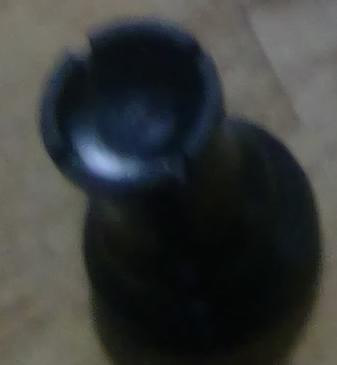

00040_black-king.jpg  |  1


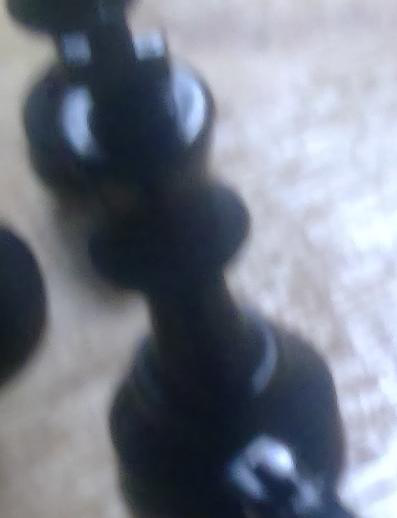

00044_white-bishop.jpg  |  3


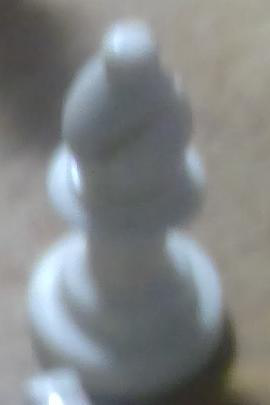

00041_black-bishop.jpg  |  2


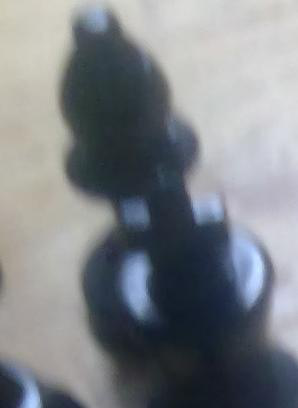

00000_white-knight.jpg  |  0


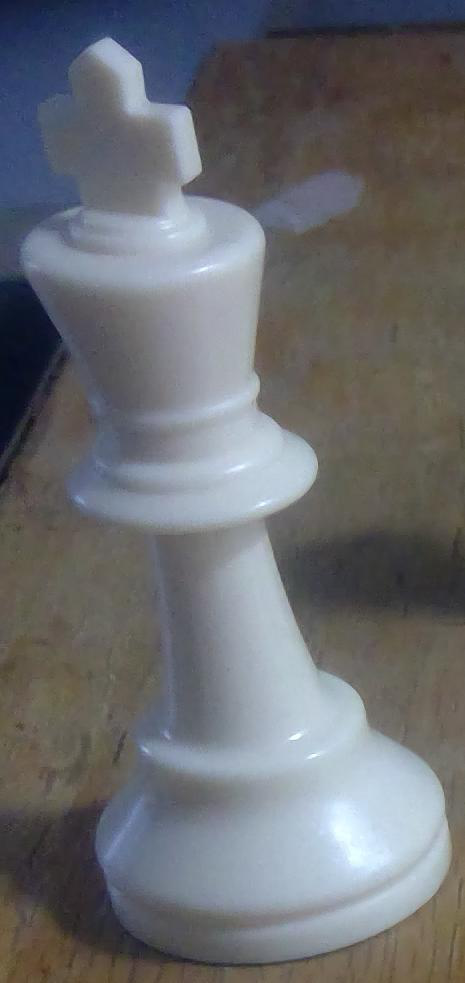

00038_white-king.jpg  |  0


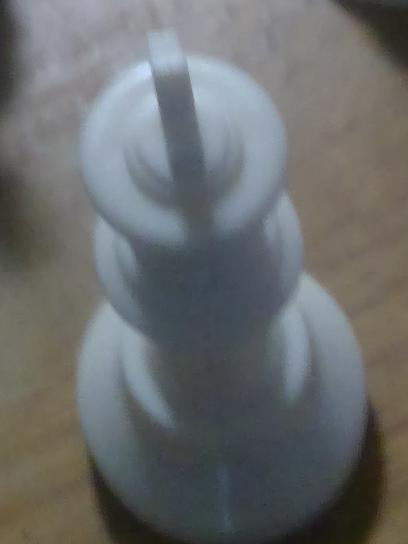

In [145]:
for imgfn, numcorrect in zip(difficult_imgfns, difficult_numcorrect):
    print(imgfn.name, ' | ', str(numcorrect) )
    display(Image.open(imgfn))

##### which images are always right?

In [148]:
df_correct.shape

(60, 17)

In [151]:
d_preds.keys()

dict_keys(['expmod-b-2', 'expmod-a-0', 'expmod-a-2', 'expmod-b-3', 'expmod-a-6', 'expmod-a-3', 'expmod-a-7', 'expmod-b-6', 'expmod-a-5', 'expmod-a-8', 'expmod-b-0', 'expmod-b-4', 'expmod-b-7', 'expmod-a-1', 'expmod-b-5', 'expmod-b-1', 'expmod-a-4'])

In [150]:
len(d_preds.keys())

17

In [155]:
min_correct = 17
mask_easy = (df_correct.sum(axis=1) >= min_correct)
easies = df_pred[mask_easy]
easies

,fn,label,actual,pred_expmod-b-2,loss_expmod-b-2,pred_expmod-a-0,loss_expmod-a-0,pred_expmod-a-2,loss_expmod-a-2,pred_expmod-b-3,...,pred_expmod-b-7,loss_expmod-b-7,pred_expmod-a-1,loss_expmod-a-1,pred_expmod-b-5,loss_expmod-b-5,pred_expmod-b-1,loss_expmod-b-1,pred_expmod-a-4,loss_expmod-a-4
2,00013_black-rook.jpg,black-rook,5,5,0.041660,5,0.005947,5,0.231042,5,...,5,0.051068,5,0.001657,5,0.000771,5,0.006509,5,0.003965
7,00022_black-king.jpg,black-king,1,1,0.002314,1,0.026301,1,0.138908,1,...,1,0.054692,1,0.031260,1,0.018925,1,0.013008,1,0.009878
8,00023_black-knight.jpg,black-knight,2,2,0.026793,2,0.005399,2,0.004127,2,...,2,0.029831,2,0.013136,2,0.018794,2,0.005352,2,0.048018
17,00027_white-knight.jpg,white-knight,8,8,0.033734,8,0.180274,8,0.144800,8,...,8,0.151680,8,0.049270,8,0.024255,8,0.266058,8,0.320712
18,00002_black-knight.jpg,black-knight,2,2,0.024626,2,0.012649,2,0.045851,2,...,2,0.017642,2,0.033630,2,0.029031,2,0.016760,2,0.031554
21,00035_black-knight.jpg,black-knight,2,2,0.019860,2,0.004774,2,0.018764,2,...,2,0.016816,2,0.009767,2,0.004589,2,0.004568,2,0.005114
25,00012_white-king.jpg,white-king,7,7,0.447794,7,0.145826,7,0.066084,7,...,7,0.062682,7,0.140826,7,0.011251,7,0.457795,7,0.000052
28,00004_white-pawn.jpg,white-pawn,9,9,0.001501,9,0.004907,9,0.001011,9,...,9,0.004362,9,0.051306,9,0.093475,9,0.001990,9,0.022397
40,00042_white-rook.jpg,white-rook,11,11,0.004853,11,0.004581,11,0.055548,11,...,11,0.000953,11,0.163192,11,0.004877,11,0.000542,11,0.060932
44,00003_white-knight.jpg,white-knight,8,8,0.002961,8,0.011299,8,0.009117,8,...,8,0.025362,8,0.042514,8,0.011572,8,0.021429,8,0.047485


00013_black-rook.jpg  |  17


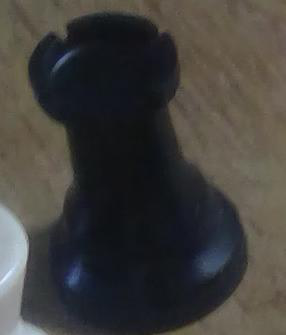

00022_black-king.jpg  |  17


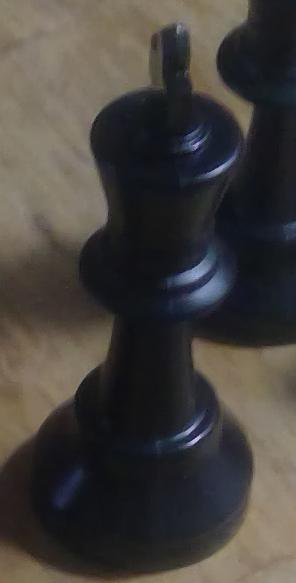

00023_black-knight.jpg  |  17


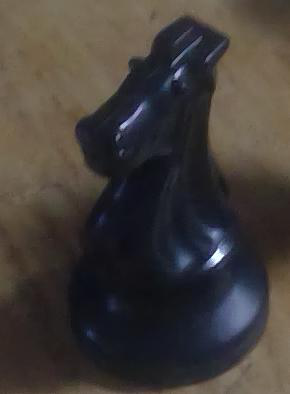

00027_white-knight.jpg  |  17


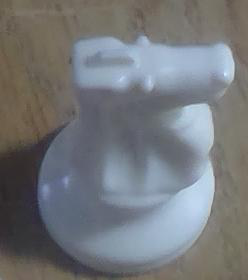

00002_black-knight.jpg  |  17


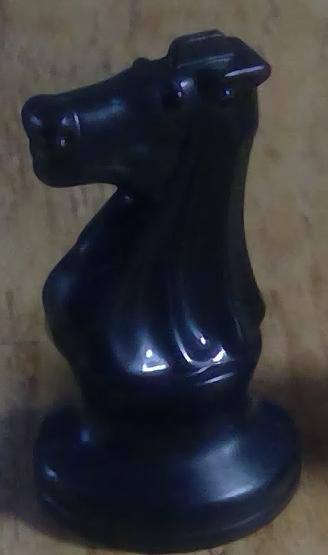

00035_black-knight.jpg  |  17


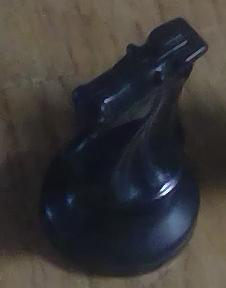

00012_white-king.jpg  |  17


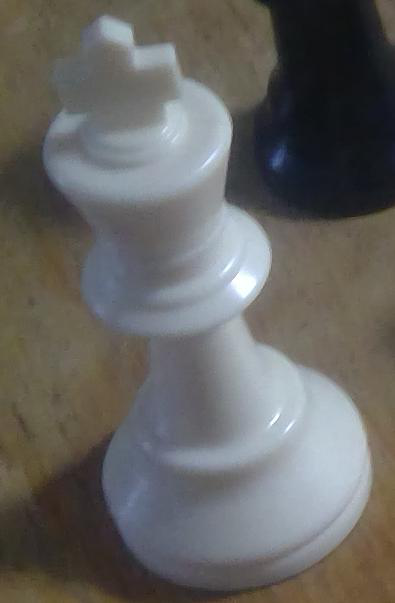

00004_white-pawn.jpg  |  17


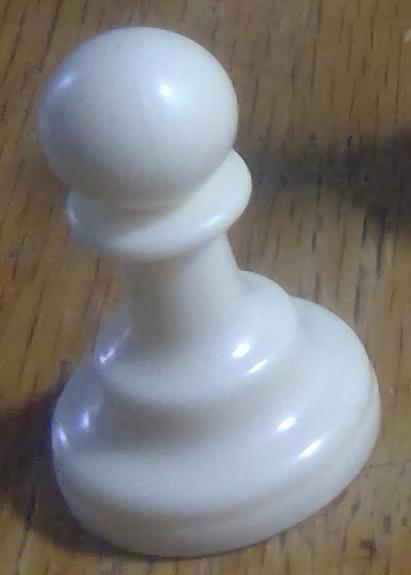

00042_white-rook.jpg  |  17


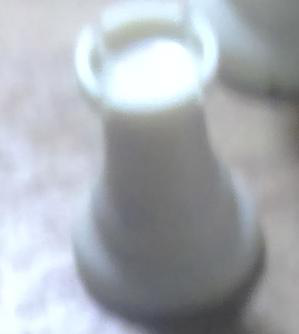

00003_white-knight.jpg  |  17


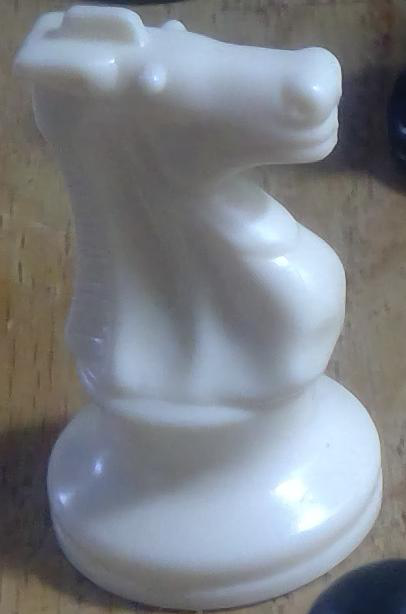

In [156]:
easy_imgfns = [test_path / e for e in easies['fn'].tolist()]
easy_numcorrect = df_correct.sum(axis=1)[mask_easy]

for imgfn, numcorrect in zip(easy_imgfns, easy_numcorrect):
    print(imgfn.name, ' | ', str(numcorrect) )
    display(Image.open(imgfn))